# SiPMs calibration

1) Read the data from a txt file, the data are the spectum of the SiPMs with led and no-led light
2) Fit the histograms to n-gaussian
3) Plot the results
4) Plot the spectrum of the SiPMs which parameters are in the tail of its distributions

In [1]:
from __future__ import print_function

### Revision

In [2]:
import time
print(time.strftime("%d/%m/%Y"),' ',time.strftime("%H:%M:%S"))

29/10/2016   17:08:25


### Dependencies

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import tables
import pandas as pd
import time

In [5]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.mlab import griddata
matplotlib.style.use('ggplot')

In [6]:
pp = %env PYTHONPATH
print(pp)
#from Nh5 import *

/Users/hernando/Software/root/lib:/Users/hernando/Software/lib:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Core:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Config:/Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/IC/Sierpe


### DB  

In [7]:
icdat = '/Users/hernando/Investigacion/NEXT/Data/NEWMCStar/'
ifdat = 'nexus_NEW_NEXT_v0_08_00_Kr_ACTIVE_5bar_1000kev_0.next_10000.root.h5'
h5in =tables.open_file(icdat+ifdat,'a')

In [8]:
# the sipm raw data table (all events)
sipmrd = h5in.root.sipmrd
# number of events, sipms, and w.f.length
nevts,nsipms,nshapes = sipmrd.shape[0],sipmrd.shape[1],sipmrd.shape[2]
print('number of events {}, number of sipms {}, wf length {}'.format(nevts,nsipms,nshapes))

# DB position of the (ordered) SiPMs 
sipmdb = h5in.root.Sensors.DataSiPM
print('DB for a SIPM index {}, {}'.format(0,sipmdb[0]))
h5index_of_sensorid = {sipmdb[i][0] : i for i in range(nsipms) }
i0 = sipmdb[0][0]
print('h5index of sensor id [{}]={}'.format(i0,h5index_of_sensorid[i0]))

def sipm_position_of_sensorid(senid):
    if (not h5index_of_sensorid.has_key(senid)): return [-200.,-200,0.]
    h5index = h5index_of_sensorid[senid]
    pos = sipmdb[h5index][2]
    return pos

senid=1000
pos = sipm_position_of_sensorid(senid)
print('position of sensor id {} = {}'.format(senid,pos))

number of events 1000, number of sipms 1789, wf length 1200
DB for a SIPM index 0, (1000, 1, [-235.0, 45.0, -10000.0], 1.0, 15.5)
h5index of sensor id [1000]=0
position of sensor id 1000 = [  -235.     45. -10000.]


### SiPM calibration data

In [9]:
indir = '/Users/hernando/Investigacion/NEXT/Data/NEWStar/sipmcalib/160923/'
irun='2105'
infile = 'sipmCal_singlePulse_R'+irun

In [10]:
# input calibration data: dark current and led
import calib as sc
called = sc.CalData(indir+infile+'_led.txt')
caldark = sc.CalData(indir+infile+'_dark.txt')

loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/sipmCal_singlePulse_R2105_led.txt
number of sensors with data 1792
loaded calibration data from file /Users/hernando/Investigacion/NEXT/NEXT-Reco/icnew/Data/NEW/sipmcalib/160923/sipmCal_singlePulse_R2105_dark.txt
number of sensors with data 1792


In [11]:
# create pdf file to put the figures
from matplotlib.backends.backend_pdf import PdfPages
pdf = None

In [14]:
def position_of_indexes(indexes):
    senids = map(sc.sipm_sensorid_of_index,indexes)
    pos = map(sipm_position_of_sensorid,senids)
    return np.array(pos)

In [15]:
# take the reference values
xbins = called.xbins
indexes = called.indexes
positions = position_of_indexes(indexes)

## Calibration

### calibration to ngaussians

In [16]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
id = indexes[20]
chi2,pss = sc.cal_fit_ngauss(called, [id, ], ngauss=7)
print(' chi2 {} pss {} '.format(chi2, pss))

 chi2 [17.65642172571475] pss [array([  1.03992935e-01,   1.71877212e+01,   1.72211203e+00,
         1.73436393e+00,   4.59611009e+03,   7.64468773e+03,
         7.32804755e+03,   4.75826758e+03,   2.63891149e+03])] 


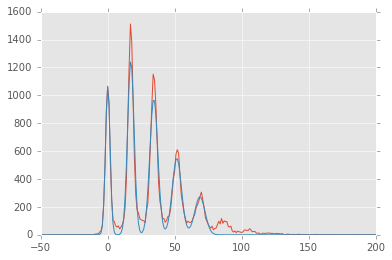

In [17]:
xs, ys = called.xbins, called.values[id]

#fig, axes = plt.subplots(2,1)
plt.plot(xs,ys)

ps = pss[0]
ffun = sc.ffun_ngauss
fys =ffun(ps,xs)
plt.plot(xs,fys)

In [18]:
#chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
chi2,pss = sc.cal_fit_ngauss(called,indexes,ngauss=7)
zpss = zip(indexes,pss)

fitting data...
fitting data...
fitting data...
fitting data...
fitting data...


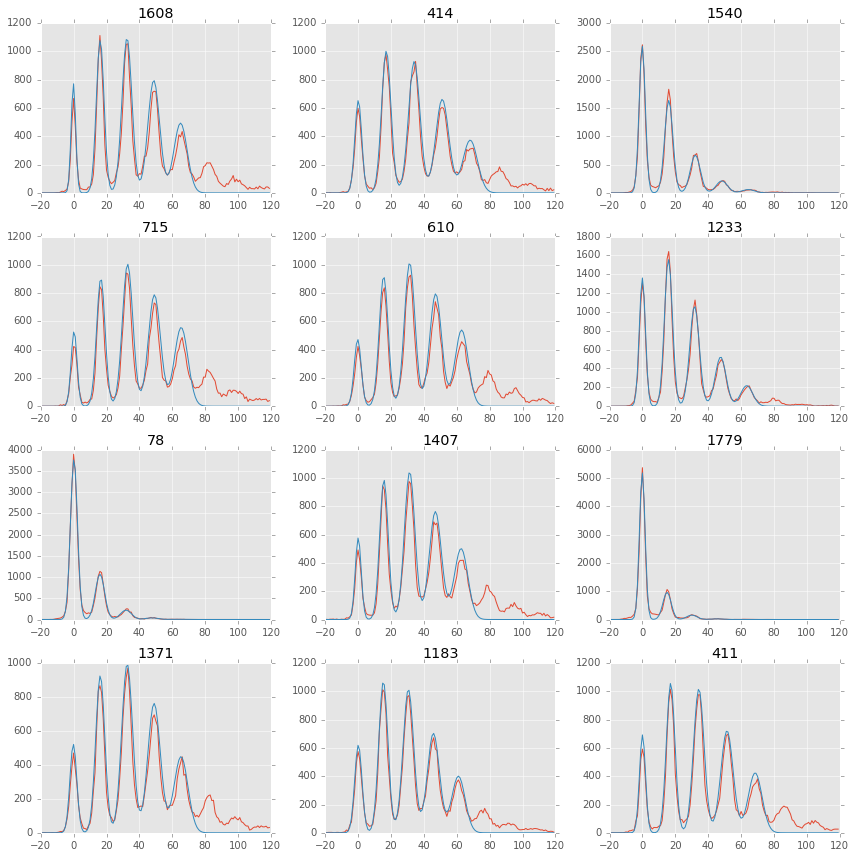

In [19]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_ng_fits.pdf')
fun = sc.ffun_ngauss
fig = sc.polo_cal_fit(called,indexes[:12],pss[:12],fun,xrange=(-20.,120.))
if (pdf): pdf.savefig(fig)
pdf.close()

## store the data in pandas 

In [20]:
pan = sc.cal_fit_ngauss_panda(indexes, chi2, pss)

In [21]:
pan.describe()

chi2         gain      indexes        noise     noise-pe  \
count  1792.000000  1792.000000  1792.000000  1792.000000  1792.000000   
mean     19.698187    16.227810   895.500000     1.928990     1.852145   
std       8.922228     0.914237   517.450159     0.480757     0.638288   
min       0.510751    12.000000     0.000000     1.156415     0.500000   
25%      12.503012    15.778361   447.750000     1.594764     1.701764   
50%      20.990846    16.171733   895.500000     1.837870     1.797802   
75%      26.587475    16.653750  1343.250000     2.117317     1.905584   
max     120.253028    28.539484  1791.000000     5.931541    10.000000   

               ntot     pedestal          pes  
count   1792.000000  1792.000000  1792.000000  
mean   26541.235710     0.218134     1.850337  
std     1597.569611     0.705997     0.751372  
min    13701.756178   -10.000000     0.000015  
25%    25346.367405    -0.100176     1.548502  
50%    26307.338525     0.005760     2.145490  
75%    27865.803202     0.193791     2.403579  
max    29939.474827     4.205188     4.656133

In [23]:
pan.to_hdf(indir+'calf_R'+irun+'_ng_panda.h5','df',mode='w',format='table',data_columns=True)
pan.to_csv(indir+'calf_R'+irun+'_ng_panda.csv')

## Plotting

### Plotting parameters

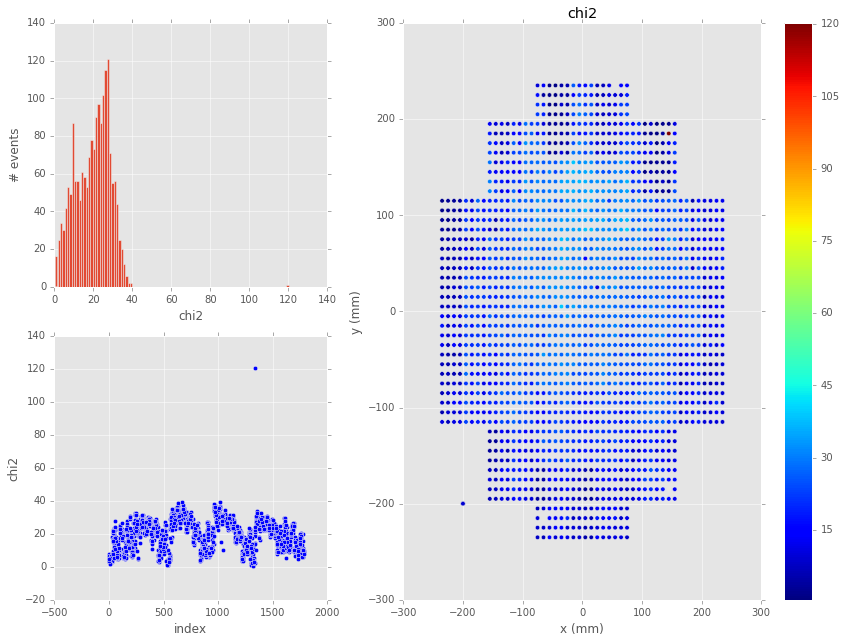

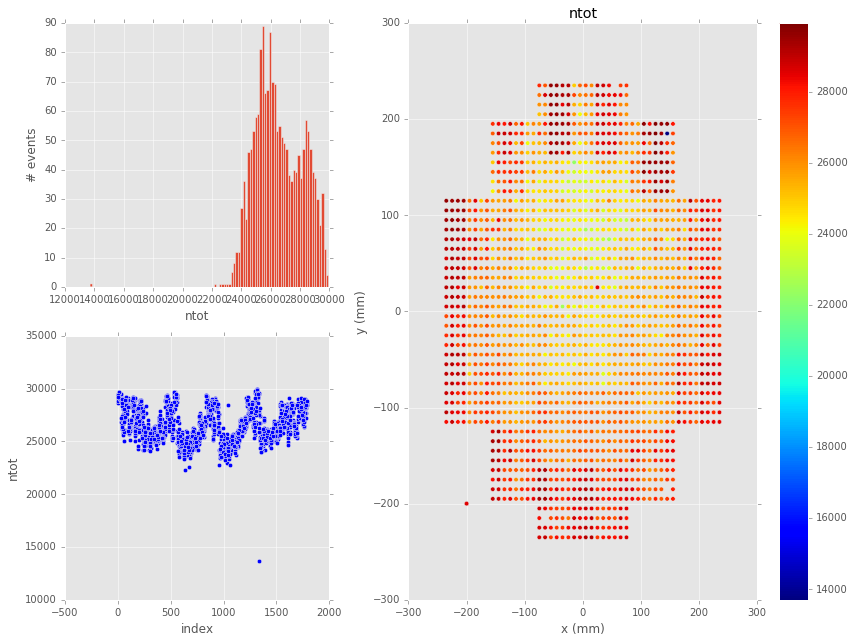

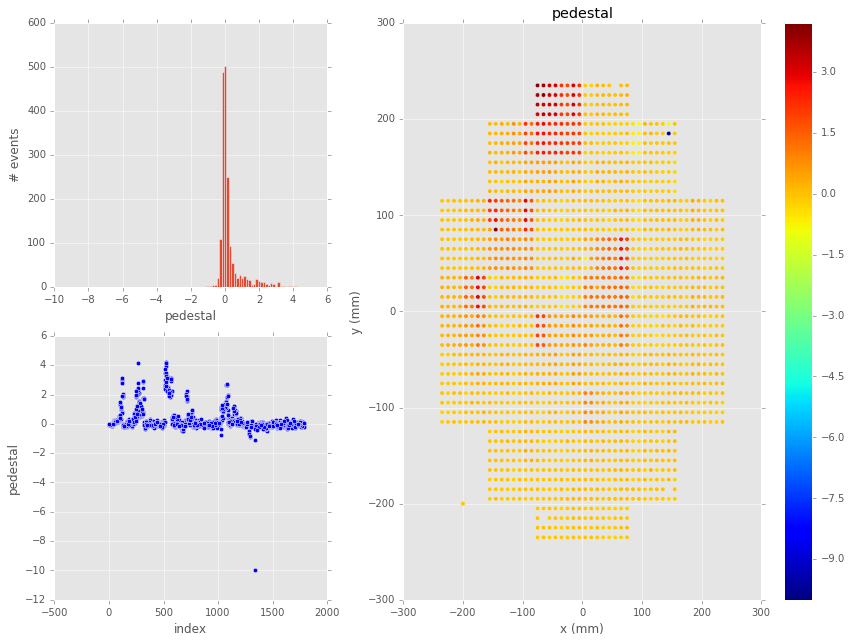

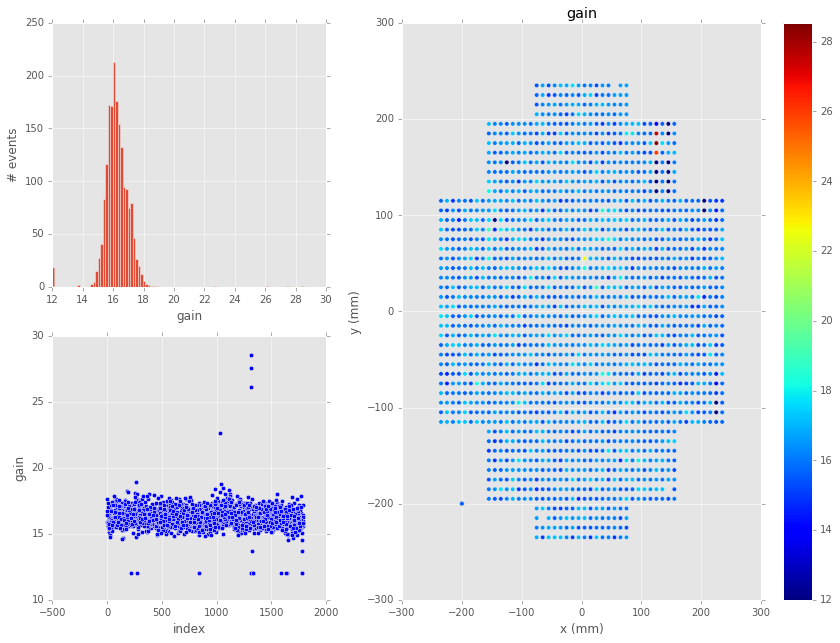

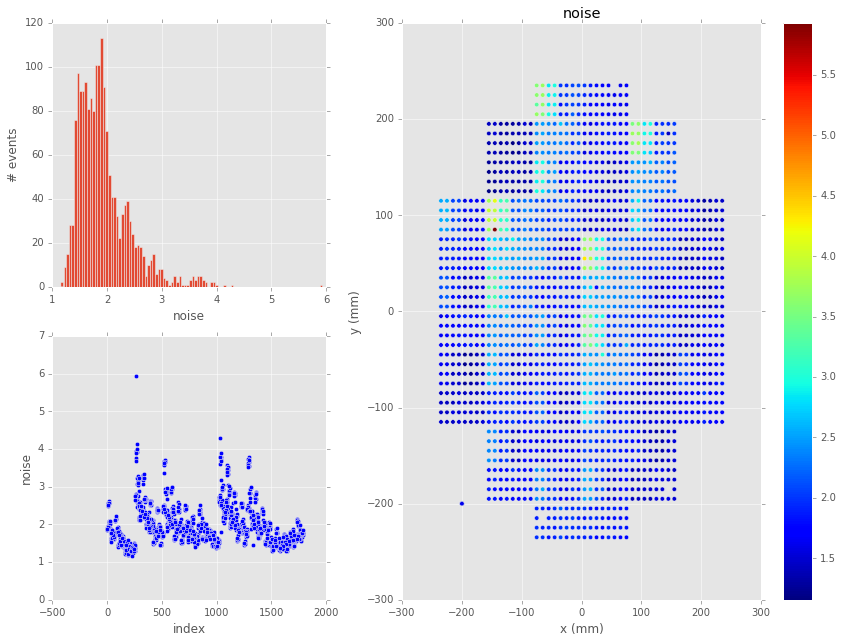

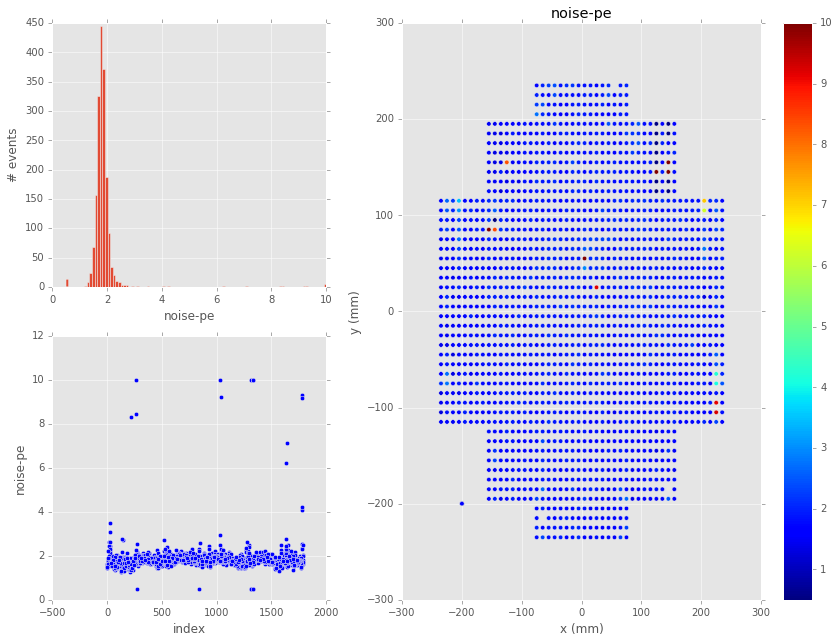

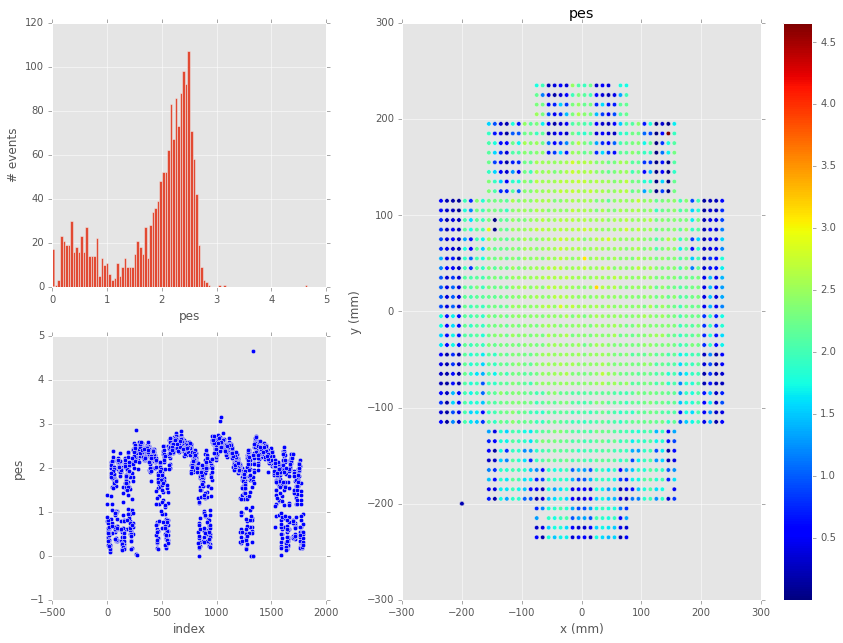

In [28]:
pdf = None
pdf = PdfPages(indir+'calf_R'+irun+'_ng_figs.pdf')
labels = ['chi2','ntot','pedestal','gain','noise','noise-pe','pes']
for label in labels:
    fig = sc.polo_pars(pan['indexes'],pan[label],positions,label=label)
    if (pdf): pdf.savefig(fig)
pdf.close()

In [29]:
zpss = zip(indexes,pss)
def pss_filter(findexes,zpss):
    ixs = list(findexes)
    fzs = filter(lambda z: z[0] in ixs,zpss)
    fpss = map(lambda z: z[1],fzs)
    return fpss

In [30]:
### Plotting SiPM spectrum of SiPMs with parameters in the tails of the distributions

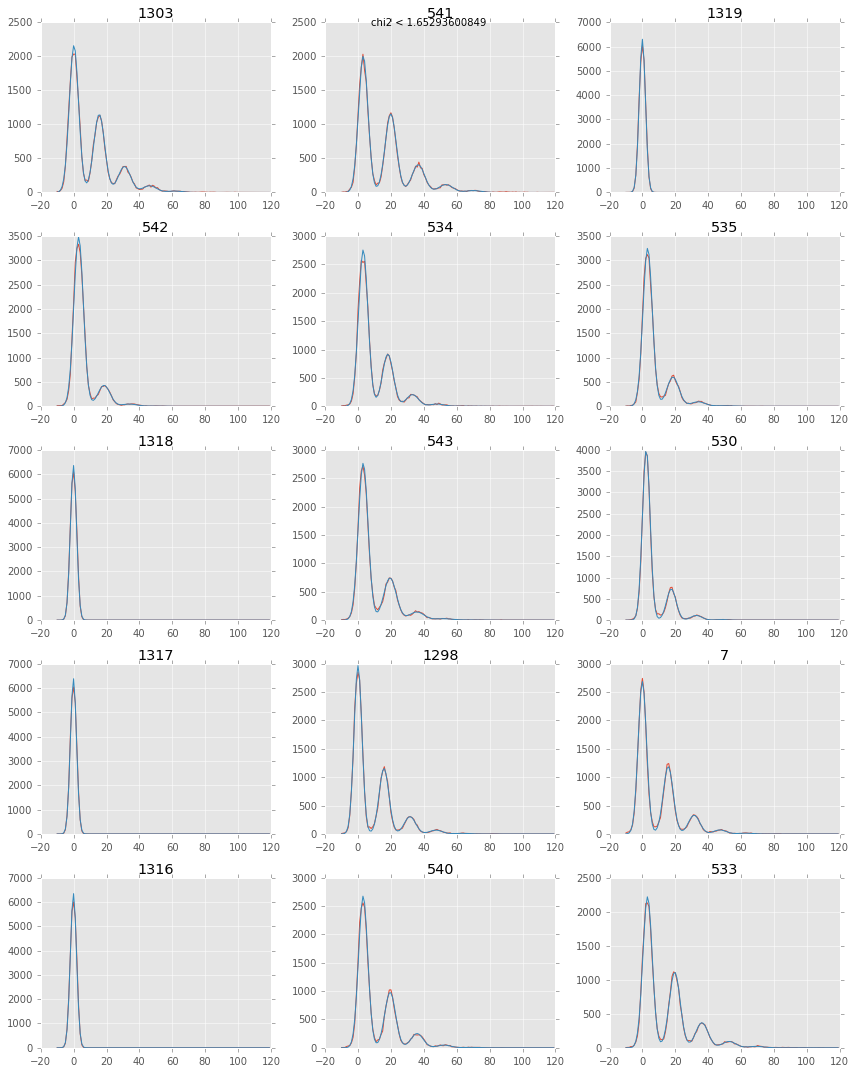

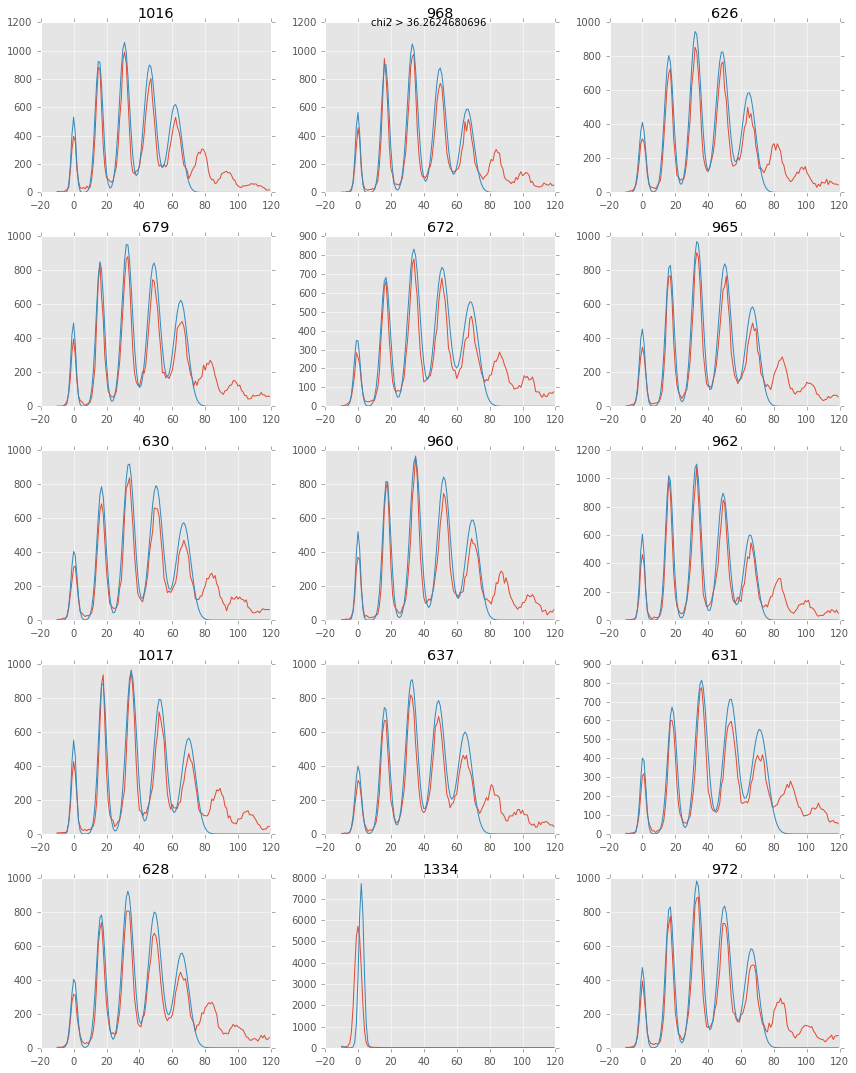

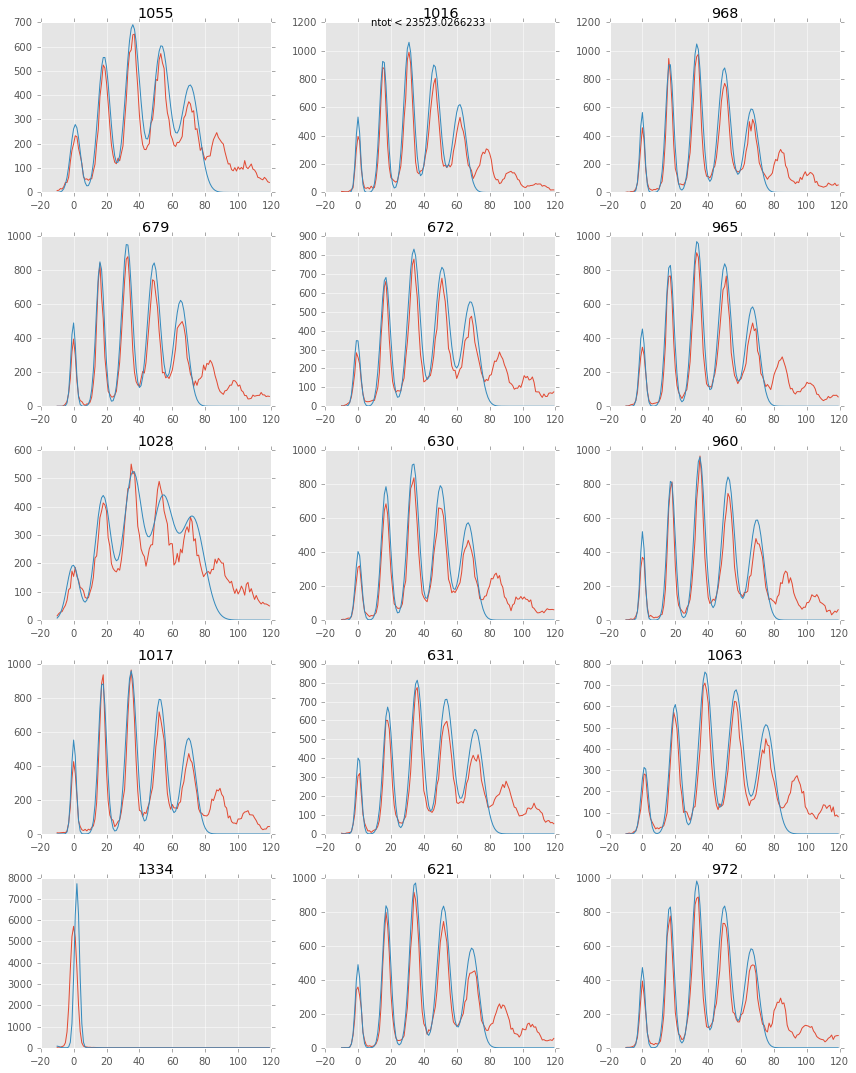

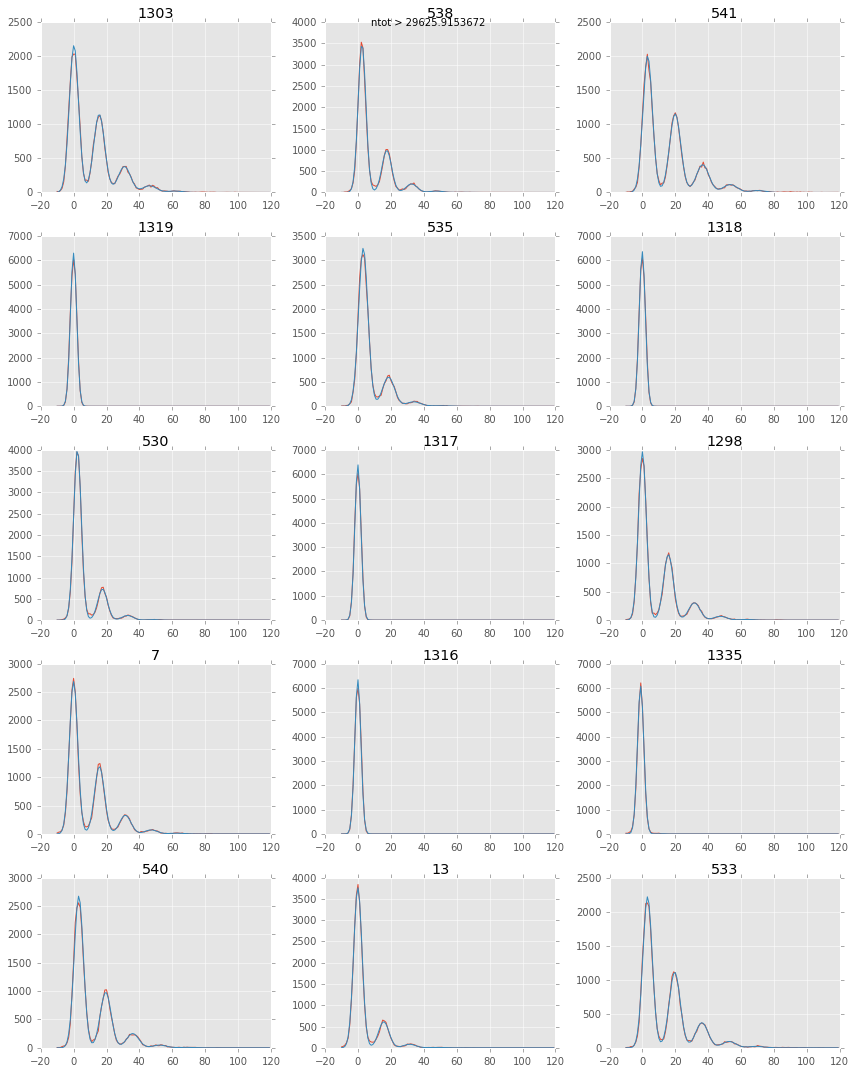

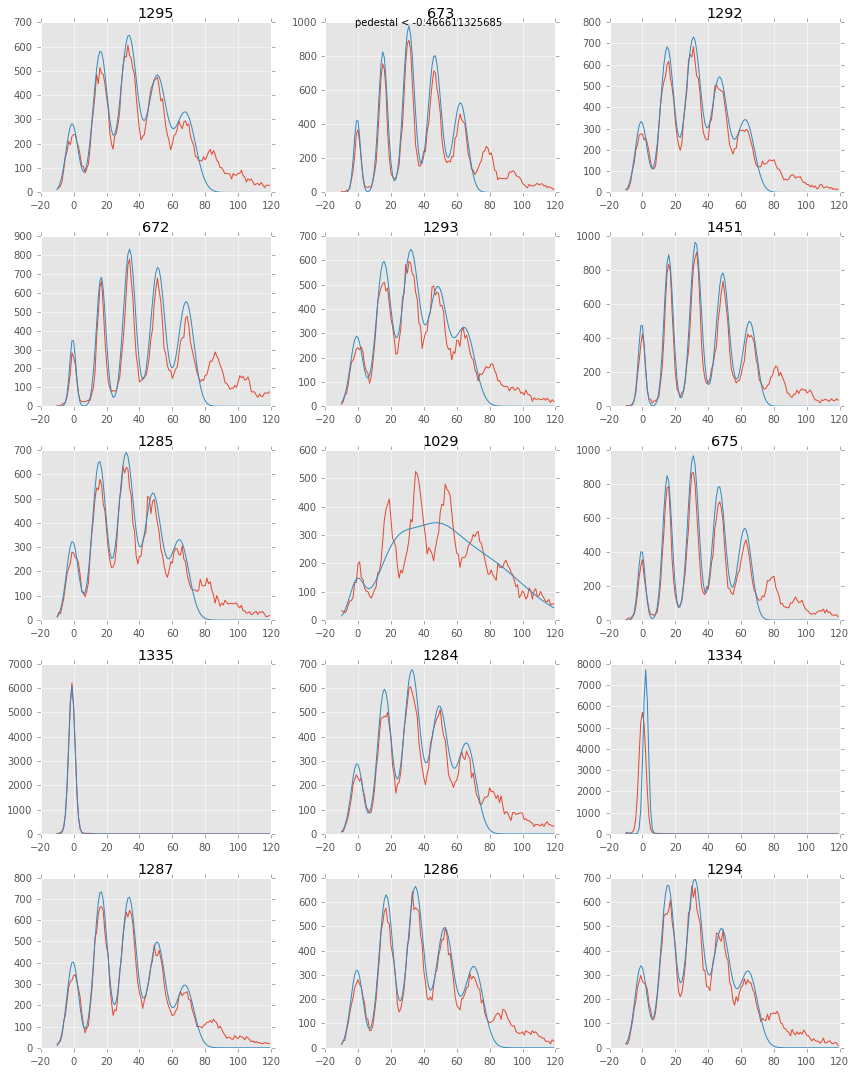

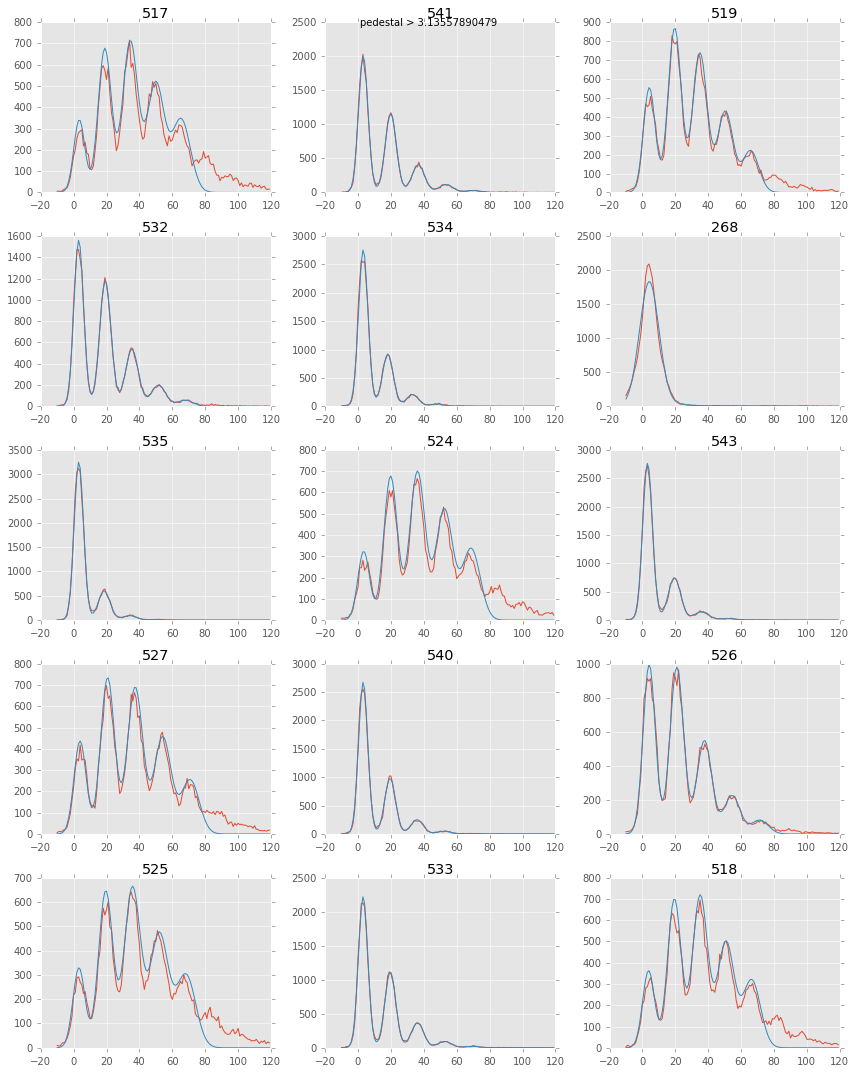

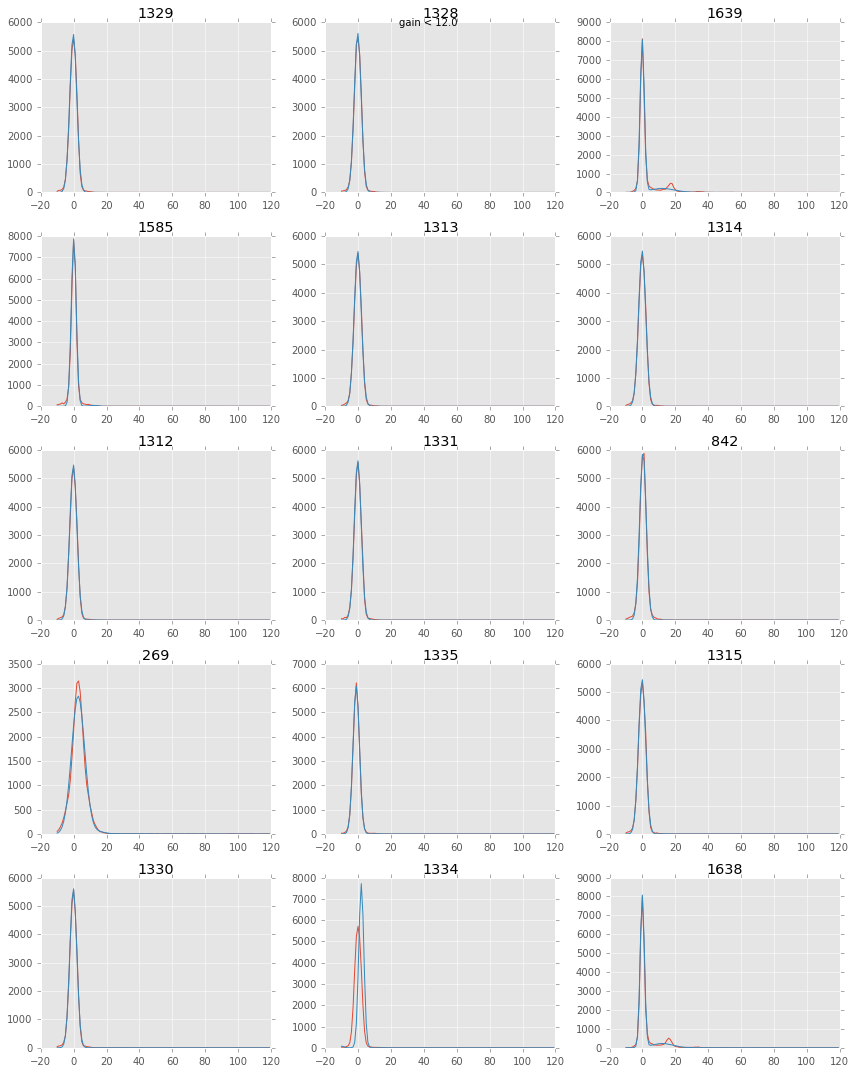

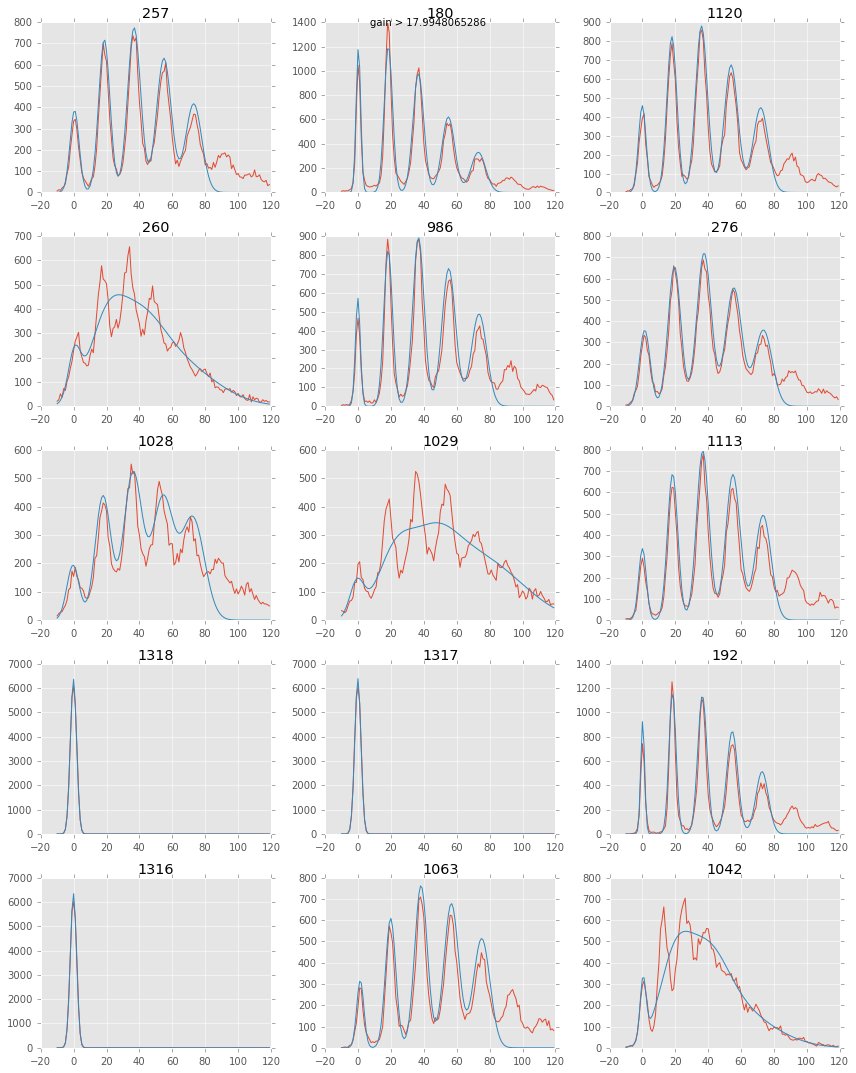

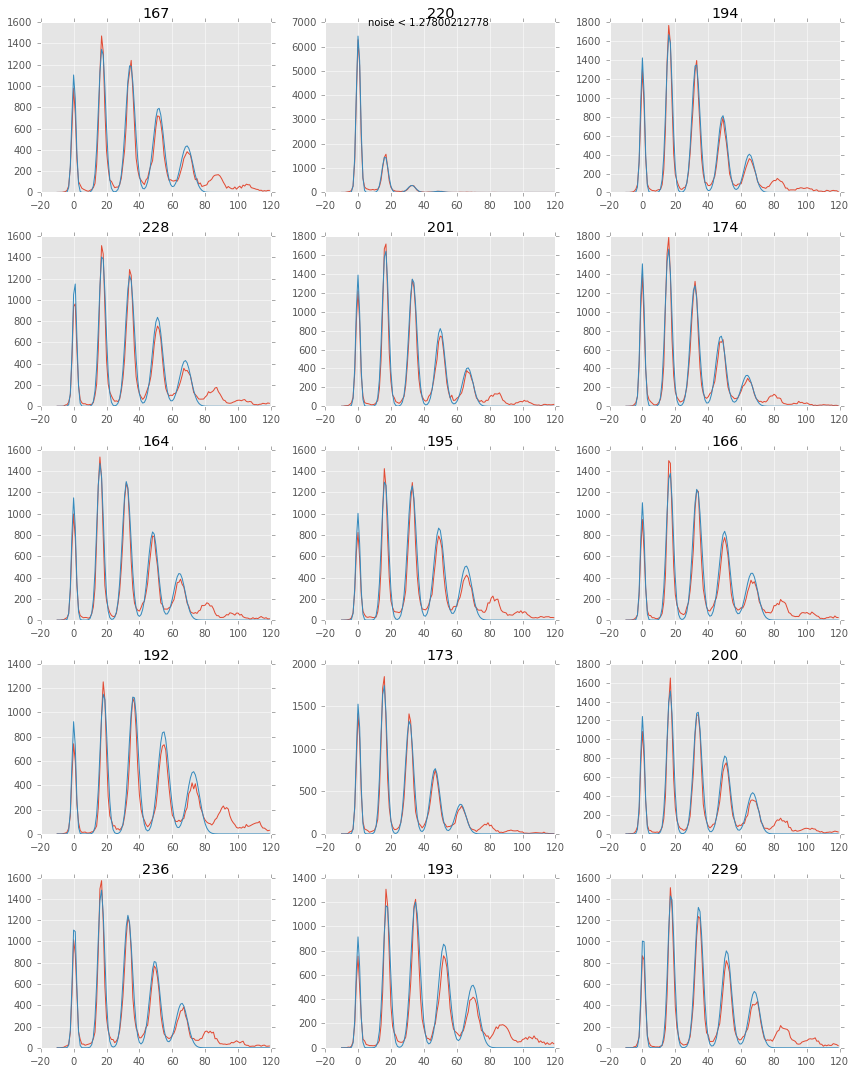

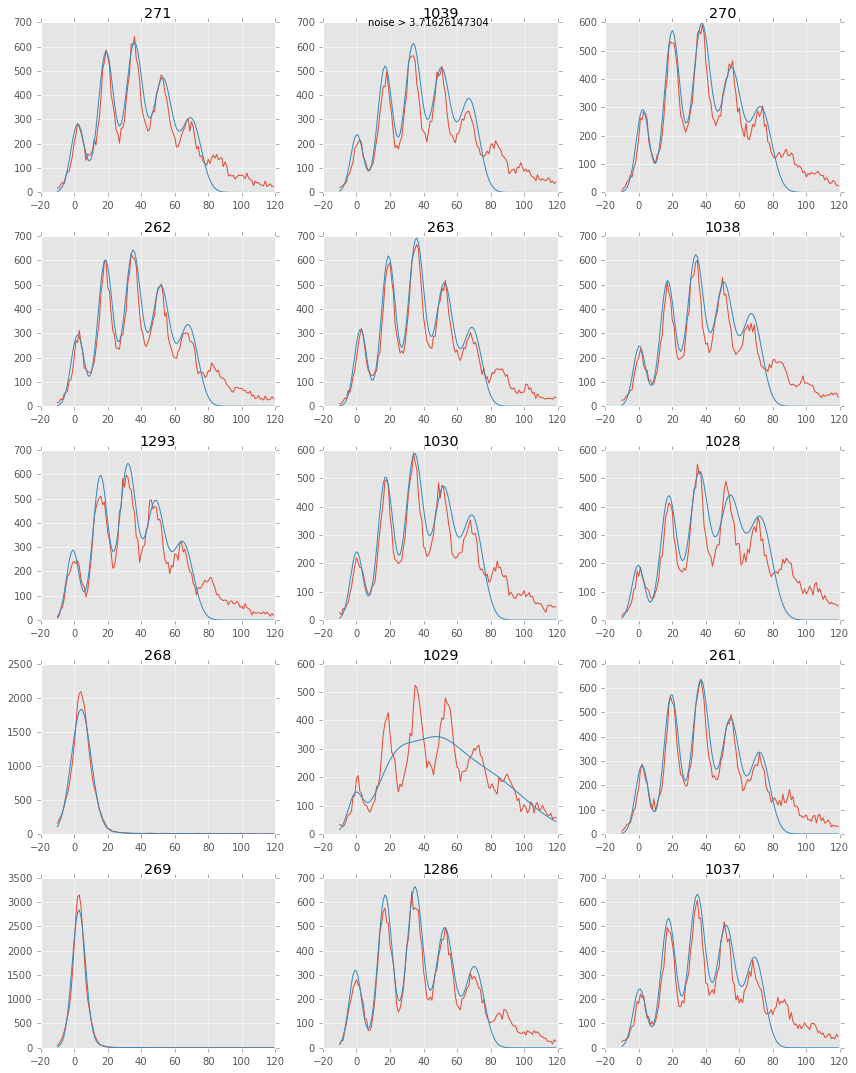

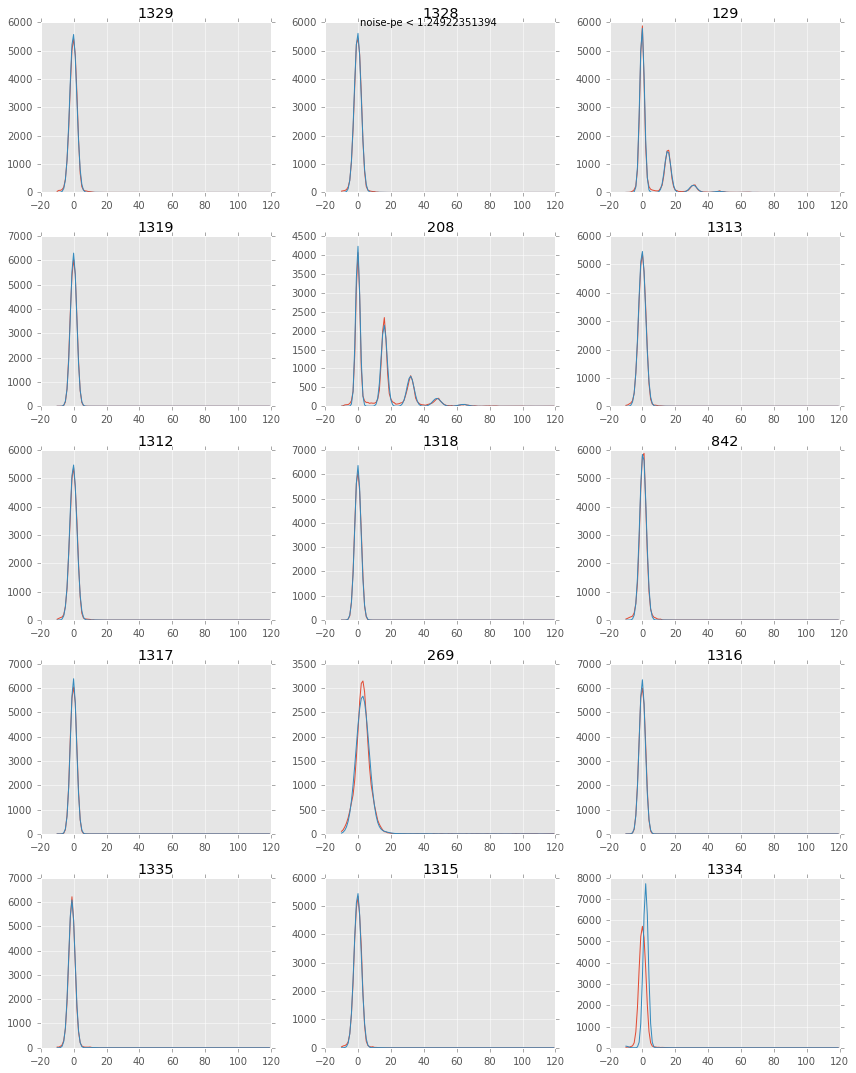

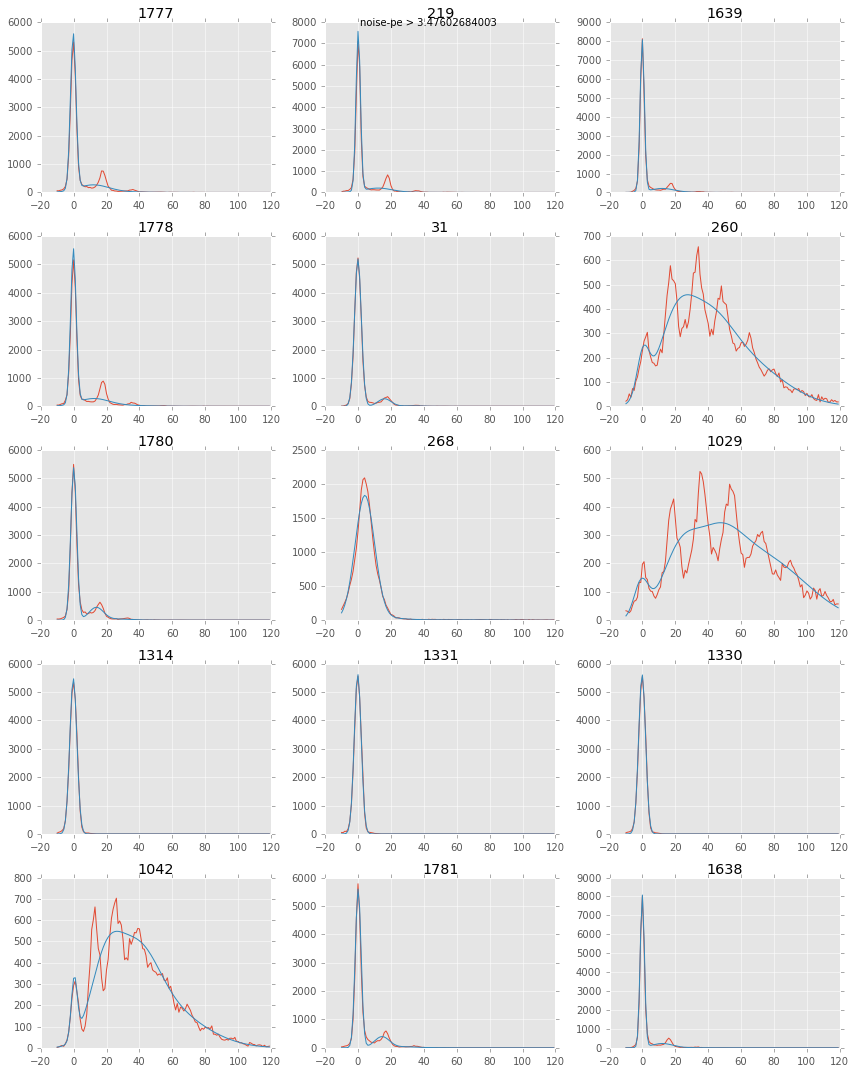

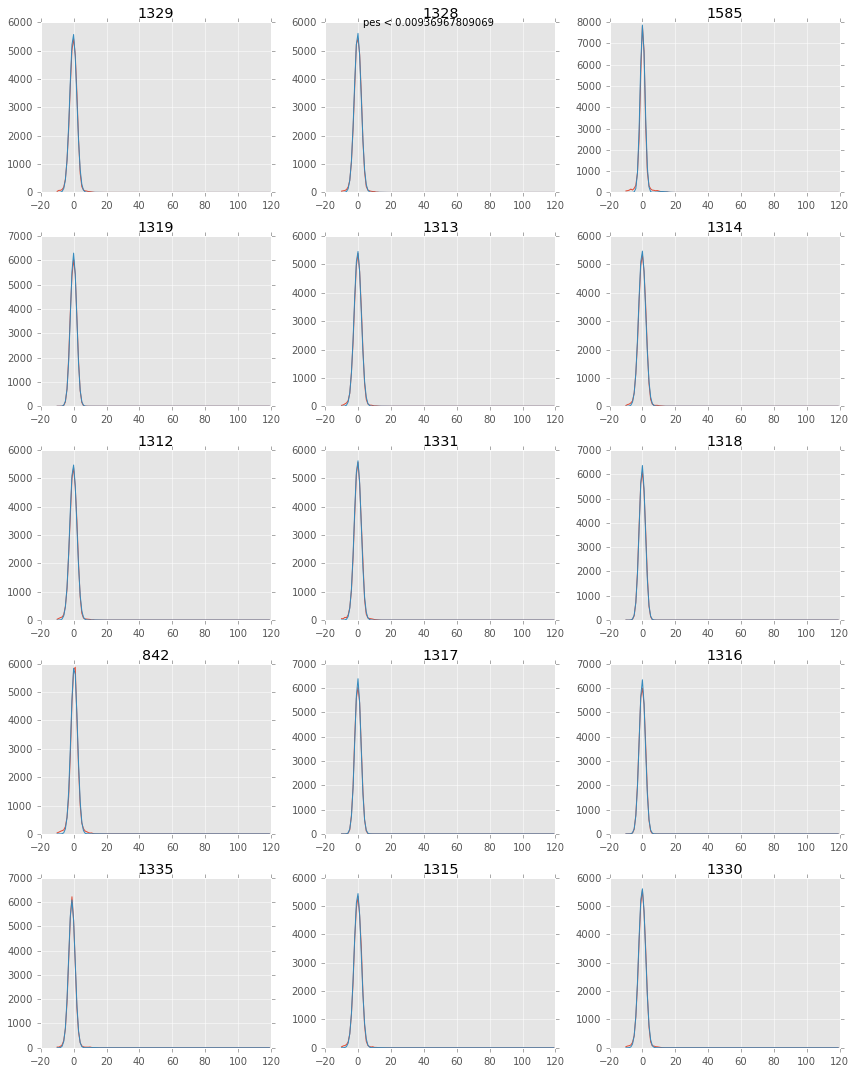

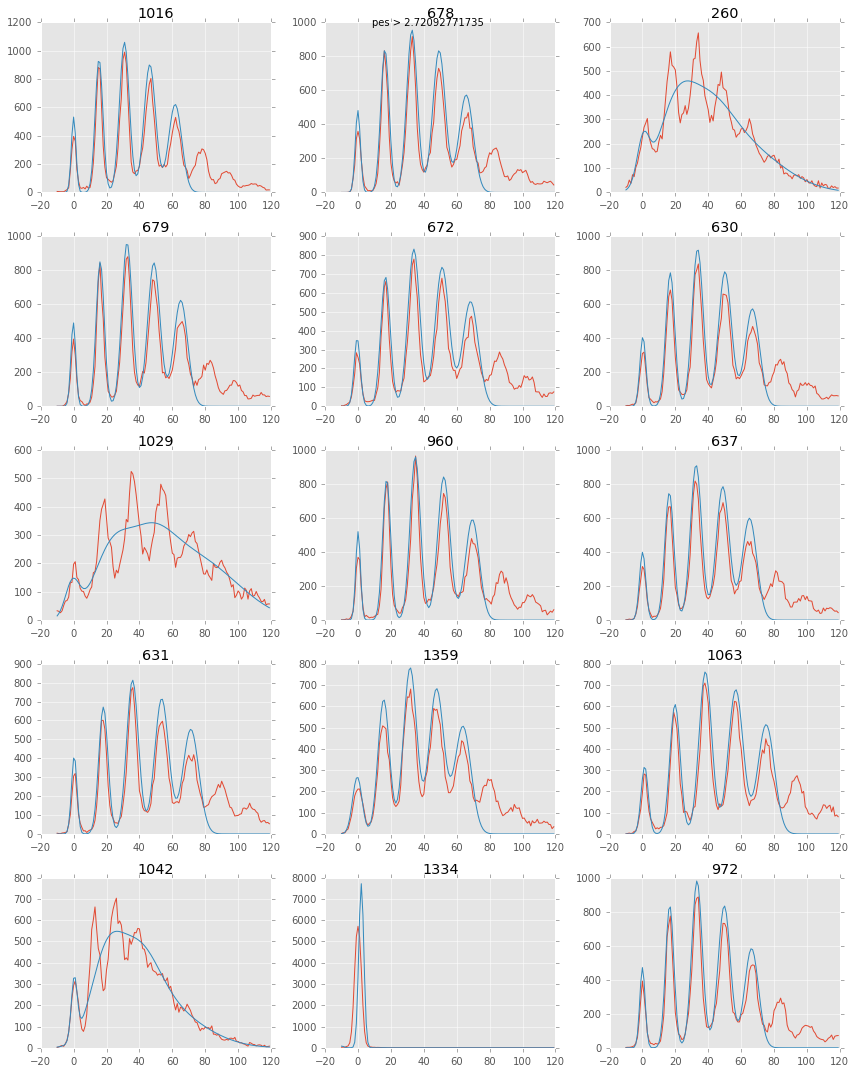

In [31]:
labels=['chi2','ntot','pedestal','gain','noise','noise-pe','pes']
percentile=0.008

pdf = PdfPages(indir+'calf_R'+irun+'_ng_figs_tails.pdf')

for label in labels:
    val0,valf = sc.np_percentile(pan[label],percentile=percentile)
    fpan = pan[pan[label]<=val0]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' < '+str(val0)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
    fpan = pan[pan[label]>=valf]
    findexes = fpan['indexes']
    fpss = pss_filter(findexes,zpss)
    title = label+' > '+str(valf)
    fig = sc.polo_cal_fit(called,findexes,fpss,fun,xrange=(-10.,120.),title=title)
    if (pdf): pdf.savefig(fig)
        
pdf.close()
#    fpan
#    raw_input('enter key')

That's all folks!